# 21기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [29]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df.drop(['User_ID', 'Product_ID'], inplace=True, axis=1) # 예측 작업에 불필요한 컬럼 제거

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      4998 non-null   object 
 1   Age                         4998 non-null   object 
 2   Occupation                  4998 non-null   int64  
 3   City_Category               4998 non-null   object 
 4   Stay_In_Current_City_Years  4998 non-null   object 
 5   Marital_Status              4998 non-null   int64  
 6   Product_Category_1          4998 non-null   int64  
 7   Product_Category_2          3465 non-null   float64
 8   Product_Category_3          1544 non-null   float64
 9   Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 429.5+ KB


In [32]:
df.describe()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


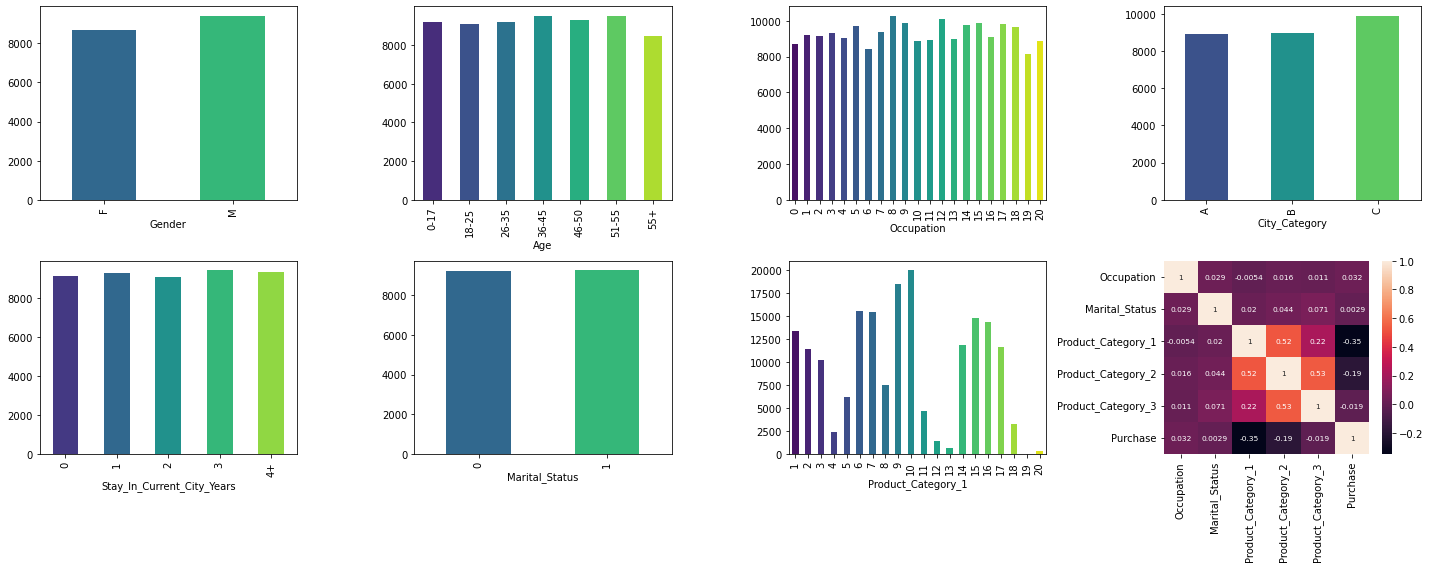

In [33]:
columns = df.columns[:7]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

# 각 컬럼 내 값들에 대한 'Purchase' 값의 분포 시각화 (Purchase 평균)
# 마지막 axs에는 히트맵을 통해 상관계수 행렬 시각화

for i, col_name in enumerate(columns):
    r = i // 4
    c = i % 4
    df.groupby(col_name)['Purchase'].mean().plot(kind='bar', ax=axs[r,c], color=sns.color_palette('viridis', len(df[col_name].unique())))
    if i == 6:
        sns.heatmap(df.corr(), annot=True, annot_kws={'fontsize':7.5}, ax=axs[1,3])

plt.tight_layout()
plt.show()

히트맵을 통해 Product_Category와 관련된 컬럼들이 Purchase와 높은 상관관계를 보임을 알 수 있음.

In [34]:
df.isnull().sum()

Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

그러나 해당 컬럼들에는 결측치가 존재함

==> **결측값을 처리하기 위해 KNNImputer 활용 (KNN을 이용해 결측치 처리)**

==> 사전 작업으로 범주형 변수들에 대해 원-핫 인코딩을 진행하여 수치형 데이터로 변환

In [35]:
# df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].apply(lambda x: x.strip('+')).astype(int)

df = pd.get_dummies(df, columns = ['Gender', 'City_Category', 'Age', 'Stay_In_Current_City_Years'], drop_first=True)

In [36]:
from sklearn.impute import KNNImputer

columns = df.columns

imputer = KNNImputer(n_neighbors=360)
df = pd.DataFrame(imputer.fit_transform(df), columns = columns)

df.isnull().sum()

Occupation                       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
Gender_M                         0
City_Category_B                  0
City_Category_C                  0
Age_18-25                        0
Age_26-35                        0
Age_36-45                        0
Age_46-50                        0
Age_51-55                        0
Age_55+                          0
Stay_In_Current_City_Years_1     0
Stay_In_Current_City_Years_2     0
Stay_In_Current_City_Years_3     0
Stay_In_Current_City_Years_4+    0
dtype: int64

In [37]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Purchase', axis=1)
y = df['Purchase']

X

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Gender_M,City_Category_B,City_Category_C,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,10.0,0.0,5.0,17.000000,13.094444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,0.0,7.0,11.066667,13.097222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10.0,0.0,1.0,4.000000,13.322222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,10.0,0.0,2.0,4.000000,13.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,10.0,0.0,3.0,5.000000,13.486111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,7.0,1.0,1.0,16.000000,11.933333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4994,1.0,1.0,8.0,10.458333,13.094444,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4995,13.0,1.0,1.0,6.000000,14.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4996,0.0,1.0,12.0,10.458333,13.094444,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


다른 컬럼들에 비해 값이 큰 Occupation, Product_Category_2, Product_Category_3 컬럼에 대해 표준화 스케일링 진행

In [38]:
scaler = StandardScaler()
target_cols = ['Occupation', 'Product_Category_2', 'Product_Category_3']

for col in target_cols:
    target_data = X[col].values.reshape(-1,1)
    scaled_data = scaler.fit_transform(target_data)
    X[col] = scaled_data

In [39]:
X

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Gender_M,City_Category_B,City_Category_C,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0.304745,0.0,5.0,1.635625,0.061917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.304745,0.0,7.0,0.253126,0.063144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.304745,0.0,1.0,-1.393447,0.162532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.304745,0.0,2.0,-1.393447,0.022653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.304745,0.0,3.0,-1.160441,0.234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,-0.160945,1.0,1.0,1.402619,-0.450975,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4994,-1.092325,1.0,8.0,0.111381,0.061917,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4995,0.770435,1.0,1.0,-0.927436,0.461924,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4996,-1.247555,1.0,12.0,0.111381,0.061917,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


데이터 내 값들의 크기가 비교적 균등해졌음을 알 수 있음.

## 2. KNN 구현 & 파라미터 튜닝

### 기본 KNN 모델 생성 및 평가

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
pred = knn_reg.predict(X_test)
r2_score(y_test, pred)    

0.4760130475879174

r^2 결정계수가 0.48 가량으로 도출됨

### 그리드 서치를 통한 파라미터 튜닝

In [41]:
from sklearn.model_selection import GridSearchCV

# KNN regressor 모델 생성
knn = KNeighborsRegressor()

# 탐색할 하이퍼파라미터 그리드
param_grid = {
    'n_neighbors': range(5, 30),  # 이웃의 수
    'weights': ['uniform', 'distance'],  # 가중치
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # 알고리즘
    'p': [1, 2]  # 거리 메트릭 (1: 맨해튼 거리, 2: 유클리드 거리)
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# 그리드 서치 수행 (최적의 하이퍼파라미터 찾기)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

best_model = grid_search.best_estimator_

# 테스트 세트로 최적의 모델 평가
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("테스트 세트 R^2 점수:", r2)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


최적의 하이퍼파라미터: {'algorithm': 'kd_tree', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
테스트 세트 R^2 점수: 0.5264224467379555


그리드 서치를 통해 얻은 최적의 파라미터 조합을 통해 테스트 세트에 대한 회귀 작업을 수행한 결과, R^2 결정계수 값이 0.53 가량인 것으로 나타남.

## 3. Evaluation

### CV_score 계산

In [42]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X, y, scoring='r2', cv=5)

print('평균 CV score: ', cv_scores.mean())
print('CV score 리스트: ', cv_scores)

평균 CV score:  0.5171201064717156
CV score 리스트:  [0.51461035 0.44872049 0.50551785 0.54505454 0.5716973 ]


사이킷런에서 제공하는 cross_val_score 함수를 활용해 R^2 결정계수의 평균을 구한 결과, 0.52 가량으로 도출됨